在回归(regression)问题中，我们常使用MSE衡量模型的优劣。而在分类(classification)问题中则常用交叉熵(Cross-Entropy, CE)。为什么分类问题中不用MSE呢？下面列出两点原因：

 - **Gradient Vanish** : MSE常常搭配Sigmoid函数使用，而后者会出现梯度消失(gradient vanish)的问题；

 - **Converge Slower** : MSE的梯度相对于CE小，所以模型收敛得更慢一些；

**但是有时候也还是会用MSE的，比如一些新算法提出后可能存在一系列的问题，这时候用交叉熵难免有些苛责，即便CE理论上是要好于MSE的。**

熵的定义：对于一个分布$p$而言，它的熵衡量了识别一个样本所需要的编码长度的期望（即平均编码长度），其计算公式如下所示：
$$
H(p) = -\sum_i p_i(x) \log p_i(x)
$$

熵描述的系统的一个不稳定性，熵越大，不稳定性越强，分布也就越离散而非集中，所能给我们提供的信息量也就越多，或者说我们所需要学习的信息也就越多。比如在看完一本《红楼梦》之后我们觉得信息量很大，那是因为《红楼梦》中有很多我们并不清楚的知识。
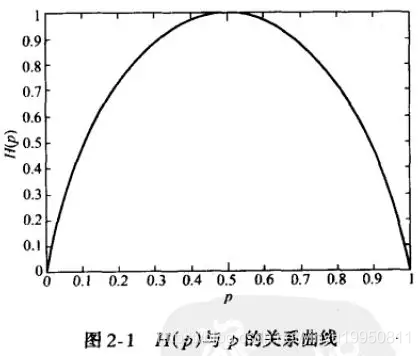

> 补充：对熵的定义中每一部分构成的理解 : 熵的定义其实主要是基于香农信息$\log \frac{1}{p(x)}$的，那么为什么香农信息长这个样子呢？我们知道，越不可能发生的事情，我们要弄明白它所需要的信息量是越多的，因此要取一个倒数。至于为什么要取对数，在我看来是因为信息量增长的速度并没有概率下降的速度那么快，不是成正比的，因此用对数来表示这种相对平缓的变化。

In [1]:
import torch
from torch.nn import functional as F

In [2]:
a = torch.full([4],1/4.)
a

tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [3]:
# 计算a的熵
-(a*torch.log(a)).sum()

tensor(1.3863)

In [4]:
b = torch.Tensor([0.1,0.1,0.1,0.7])
# 计算b的熵
-(b*torch.log(b)).sum()

tensor(0.9404)

交叉熵的定义与两个分布有关。对两个分布$p$和$q$而言，其中$p$为正确分布，$q$为错误分布，我们用它们的交叉熵表示使用错误分布$q$来表示来自真实分布$p$的平均编码长度，计算公式为：
$$
H(p,q) = -\sum_i p_i(x) \log q_i(x)   \tag{1}
$$

可以看到，$H(p,q)$并非是关于$p$和$q$对称的。因为用$q$来编码来自分布$p$的样本，所以期望中的概率为$p(i)$，$H(p,q)$称之为交叉熵, 就是来衡量用特定的编码方案Q来对分布为P的信息进行编码时需要的**平均**bits数.
还可以进一步地把上式推导为：
$$
H(p,q) = H(p) + D_{KL}(p(x)||q(x))  \tag{2}
$$

其中$D_{KL}$为*KL*散度(散开的程度)，可以衡量两个分布之间的“距离”。特别的:
- 当$p=q$时，$D_{KL}(p||q)=0$，此时$H(p,q)=H(p)$，也即交叉熵与熵相等。
- 在多分类的情况下，对输出结果进行独热编码，那么$H(p,q)=D_{KL}(p(x)||q(x))$。如对样本$x$而言，假定其输出标签为3，独热编码为$p(x)=[0,0,1]$，$x$经过神经网络的Softmax激活函数后输出为$q(x)=[0.1,0.1,0.8]$，此时$H(p)=1*\log(1)=0$。

(2)式中，从信息学角度来理解三个部分的含义：

- $H(p,q)$表示用用$q$编码$p$所需要的平均编码长度；
- $H(p)$表示编码分布为$p$的一个样本的平均长度；
- $D_{KL}(p(x)||q(x))$表示用$q$编码$p$所增加的平均编码长度

因此显然有$H(p,q) \ge H(p)$。

In [5]:
x = torch.randn(1,784)
w = torch.randn(10,784)

In [6]:
(x*w).shape

torch.Size([10, 784])

In [7]:
(x@w.t()).shape

torch.Size([1, 10])

In [8]:
logits = x@w.t()
logits

tensor([[-30.0933, -26.3787,  49.5051, -45.9024,  27.6928,  13.4984, -14.1607,
          11.8758,   0.2135,  57.2064]])

In [9]:
# 注意，在cross_entropy中其实已经集成了Softmax和Cross-Entropy，因此输入为logits
F.cross_entropy(logits, torch.tensor([3]))    

tensor(103.1093)

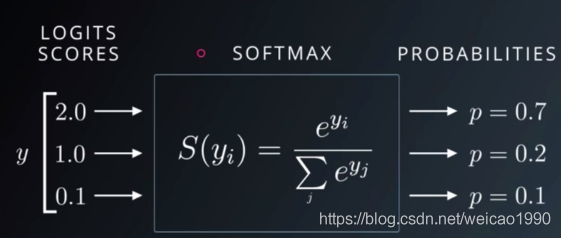

In [10]:
# 如果要硬算的话，需要经过一些特殊的处理
pred = F.softmax(logits,dim=1)
pred

tensor([[1.2190e-38, 5.0030e-37, 4.5201e-04, 1.4013e-45, 1.5213e-13, 1.0415e-19,
         1.0127e-31, 2.0557e-20, 1.7705e-25, 9.9955e-01]])

In [11]:
pred_log = torch.log(pred)
pred_log

tensor([[-8.7300e+01, -8.3586e+01, -7.7018e+00, -1.0328e+02, -2.9514e+01,
         -4.3708e+01, -7.1368e+01, -4.5331e+01, -5.6993e+01, -4.5208e-04]])

In [18]:
F.nll_loss(pred_log, torch.tensor([3]))   # CE = softmax + log + nll_loss

tensor(103.2789)

在最后说一点补充性的内容。有时候即便使用ReLU作为激活函数，仍然可能出现梯度消失的问题，即梯度长时间不会更新而保持不变，这时候应该要想一想是不是初始化出现了问题。以下代码给出了一个参数初始化的解决方案：

In [22]:
w1,b1 = torch.randn(200,784,requires_grad=True),torch.zeros(200,requires_grad=True)
w2,b2 = torch.randn(200,200,requires_grad=True),torch.zeros(200,requires_grad=True)
w3,b3 = torch.randn(10,200,requires_grad=True),torch.zeros(10,requires_grad=True)

torch.nn.init.kaiming_normal_(w1)
torch.nn.init.kaiming_normal_(w2)
torch.nn.init.kaiming_normal_(w3)

tensor([[-0.0957,  0.0480, -0.0891,  ...,  0.1055,  0.1069,  0.1580],
        [-0.0667, -0.0070, -0.0260,  ...,  0.0569,  0.0825,  0.2222],
        [ 0.1686,  0.0618,  0.0927,  ..., -0.1537,  0.1852,  0.0283],
        ...,
        [-0.0133,  0.1017, -0.0514,  ..., -0.0526, -0.0183,  0.0426],
        [ 0.1253,  0.0310,  0.0693,  ..., -0.0481,  0.0351, -0.1104],
        [-0.0477, -0.0219,  0.0086,  ...,  0.1265,  0.2460, -0.2089]],
       requires_grad=True)